# Sementic segmentation of flair1 data with a basic UNet

In [1]:
!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git
!pip install rasterio

Cloning into 'LandCover_map_Transformers_SSL'...
remote: Enumerating objects: 8742, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 8742 (delta 132), reused 279 (delta 87), pack-reused 8417
Receiving objects: 100% (8742/8742), 430.39 MiB | 14.18 MiB/s, done.
Resolving deltas: 100% (567/567), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 52.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd LandCover_map_Transformers_SSL/src

/content/LandCover_map_Transformers_SSL/src


In [4]:
# import all the necessary modules
import rasterio
from pathlib import Path
import numpy as np
from pathlib import Path
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import sys
sys.path.append('../..')
from tools.utils_Flair1 import *
from tools.metrics import PixelwiseMetrics

## Prepare the data
1) Download the data and split it into training, validation and test sets.
2) Analyse the balance of classes in the dataset.
3) Create a Dataloader
4) Load the data

In [5]:
my_set = 'fullset' # or 'subset'
data_config = {
    'train_path': '../../drive/MyDrive/MVA/flair1_' + my_set + '_13classes/train',
    'val_path': '../../drive/MyDrive/MVA/flair1_' + my_set + '_13classes/val',
    'test_path': '../../drive/MyDrive/MVA/flair1_' + my_set + '_13classes/test',
    'n_classes': 13, # number of classes in the dataset.
    'n_inputs': 5, # number of channels in input data
    'seed': 42,
    'batch_size': 32,
}

In [7]:
train_ds = Flair1Dataset(data_config['train_path'])
val_ds = Flair1Dataset(data_config['val_path'])
test_ds = Flair1Dataset(data_config['test_path'])

In [8]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=data_config['batch_size'], shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=data_config['batch_size'], shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=data_config['batch_size'], shuffle=True)

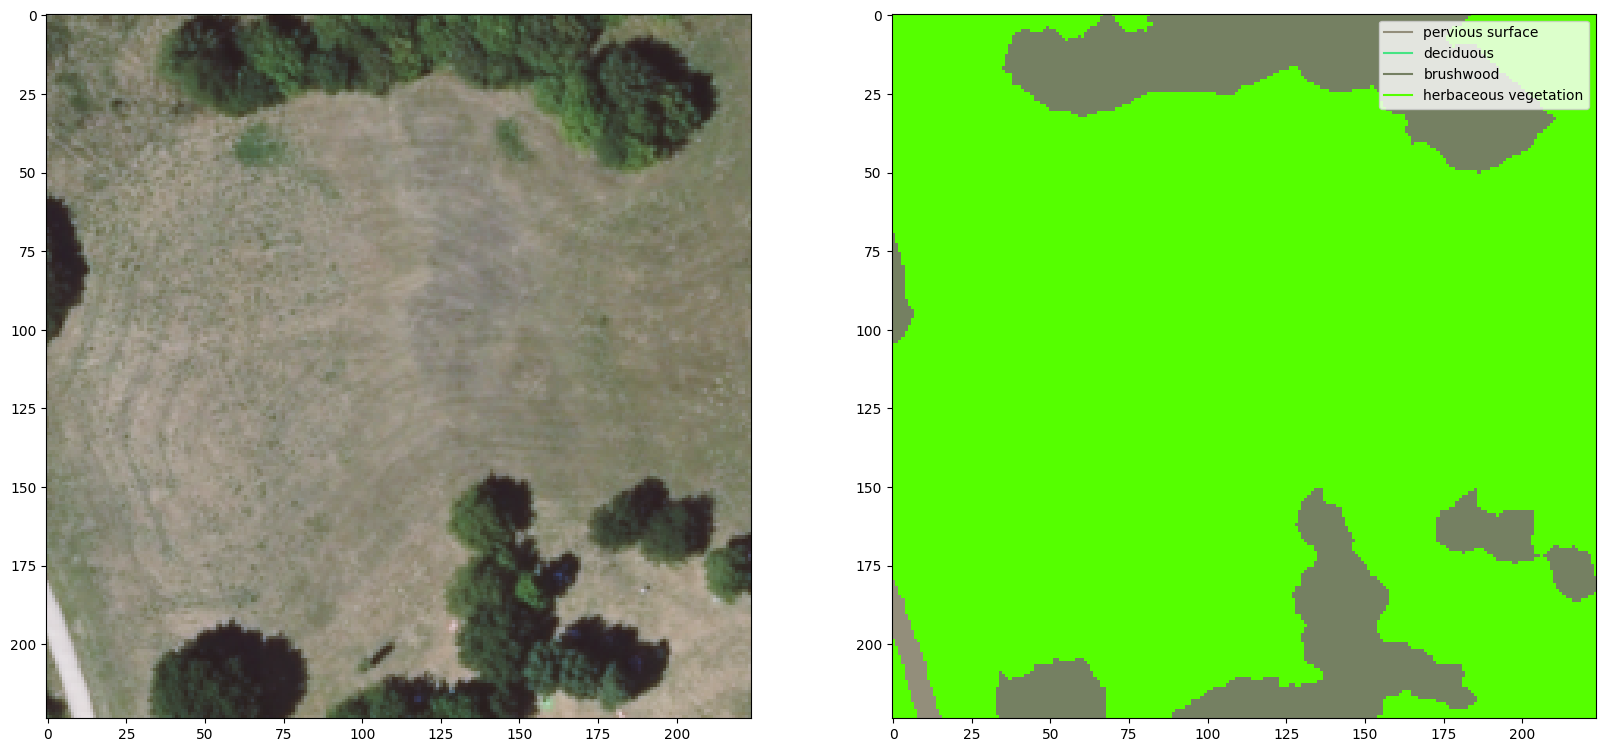

In [8]:
img, msk = next(iter(train_dl))
plot_image_mask_2(img[0], msk[0], colors_13, dict_classes_13)

## Create the model

In [9]:
import torch.nn as nn

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [10]:
# Training configurations
train_config = {
    'learning_rate': 0.001,#0.01,
    'batch_size': 32,
    'epochs': 20,
    'seed': 42,
    'weight_decay': 0,#5e-4,
    'model_path': '../../drive/MyDrive/MVA/UNet_3.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = UNet(n_classes=data_config['n_classes'], n_channels=data_config['n_inputs']) #pixel value from 1 to 13 and 5 channels
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='mean').to(device)
'''optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=train_config['learning_rate'],
    weight_decay=train_config['weight_decay']
)'''

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=train_config['learning_rate'],  # Consider using the default lr of 0.001 if you're not sure
    weight_decay=train_config['weight_decay']
)


## Train and validate

Epoch:0, Training Loss:1.507: 100%|██████████| 52/52 [05:59<00:00,  6.91s/it]


{'train_loss': 1.5068341493606567, 'train_average_accuracy': 0.39082621857439787, 'train_mIoU': 0.26649362581308134, 'train_accuracy_pixelclass_0': 0.7112933696109173, 'train_accuracy_pixelclass_1': 0.19043818516144215, 'train_accuracy_pixelclass_2': 0.7320243975079962, 'train_accuracy_pixelclass_3': 0.05871374787701885, 'train_accuracy_pixelclass_4': 0.8130534215360549, 'train_accuracy_pixelclass_5': 0.062346974931820384, 'train_accuracy_pixelclass_6': 0.8514689826025804, 'train_accuracy_pixelclass_7': 0.08219223802179641, 'train_accuracy_pixelclass_8': 0.7813198076492993, 'train_accuracy_pixelclass_9': 0.7057980616631485, 'train_accuracy_pixelclass_10': 0.08054698376002506, 'train_accuracy_pixelclass_11': 0.006429128883974284, 'train_accuracy_pixelclass_12': 0.005115542261096914, 'train_IoU_class_0': 0.48739164503047083, 'train_IoU_class_1': 0.1434591704166105, 'train_IoU_class_2': 0.4899969846841439, 'train_IoU_class_3': 0.03753054619906215, 'train_IoU_class_4': 0.5269977363783084, 

Validation Loss:1.318: 100%|██████████| 13/13 [00:25<00:00,  1.97s/it]


Epoch:0 {'validation_loss': 1.3176606893539429, 'validation_average_accuracy': 0.351573764519409, 'validation_mIoU': 0.24937917215759223, 'validation_accuracy_pixelclass_0': 0.5470306603368689, 'validation_accuracy_pixelclass_1': 0.039345364184454945, 'validation_accuracy_pixelclass_2': 0.636770721633107, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.911006329382779, 'validation_accuracy_pixelclass_5': 0.024862075410979626, 'validation_accuracy_pixelclass_6': 0.6917363614178108, 'validation_accuracy_pixelclass_7': 0.1626810015961752, 'validation_accuracy_pixelclass_8': 0.6500588709904399, 'validation_accuracy_pixelclass_9': 0.9041906470831114, 'validation_accuracy_pixelclass_10': 0.0027769067165905456, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4367432237840383, 'train_IoU_class_1': 0.03504831231226872, 'train_IoU_class_2': 0.5101764981966826, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 

Epoch:1, Training Loss:1.114: 100%|██████████| 52/52 [05:50<00:00,  6.75s/it]


{'train_loss': 1.1135591268539429, 'train_average_accuracy': 0.43819861671253996, 'train_mIoU': 0.3267113396459377, 'train_accuracy_pixelclass_0': 0.8039138719765906, 'train_accuracy_pixelclass_1': 0.2501512395551064, 'train_accuracy_pixelclass_2': 0.77565055623521, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.8405735489206579, 'train_accuracy_pixelclass_5': 0.22287366314214666, 'train_accuracy_pixelclass_6': 0.8541370930937044, 'train_accuracy_pixelclass_7': 0.21635368078041464, 'train_accuracy_pixelclass_8': 0.852891204189416, 'train_accuracy_pixelclass_9': 0.8150134338251624, 'train_accuracy_pixelclass_10': 0.06502372554461028, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5797498885607365, 'train_IoU_class_1': 0.18011287700539624, 'train_IoU_class_2': 0.5656138039646639, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.6360412984749035, 'train_IoU_class_5': 0.19978948543161926, 'train_IoU_class_6': 0.6300980

Validation Loss:1.363: 100%|██████████| 13/13 [00:26<00:00,  2.05s/it]


Epoch:1 {'validation_loss': 1.362838864326477, 'validation_average_accuracy': 0.391746366722208, 'validation_mIoU': 0.2747355492971841, 'validation_accuracy_pixelclass_0': 0.9630734864481937, 'validation_accuracy_pixelclass_1': 0.0004491200912497963, 'validation_accuracy_pixelclass_2': 0.2995097955779476, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.8756534376516535, 'validation_accuracy_pixelclass_5': 0.44716471751232795, 'validation_accuracy_pixelclass_6': 0.830899923378131, 'validation_accuracy_pixelclass_7': 0.29975462009070614, 'validation_accuracy_pixelclass_8': 0.6025234780324423, 'validation_accuracy_pixelclass_9': 0.7732764862136214, 'validation_accuracy_pixelclass_10': 0.0003977023924299149, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.19244332768180766, 'train_IoU_class_1': 0.0004487097305910148, 'train_IoU_class_2': 0.26302483081224654, 'train_IoU_class_3': 0.0, 'train_IoU_class_

Epoch:2, Training Loss:0.9924: 100%|██████████| 52/52 [05:52<00:00,  6.78s/it]


{'train_loss': 0.9923603534698486, 'train_average_accuracy': 0.474874783158478, 'train_mIoU': 0.36644628345724956, 'train_accuracy_pixelclass_0': 0.8451829524033387, 'train_accuracy_pixelclass_1': 0.27727123903160655, 'train_accuracy_pixelclass_2': 0.7895151109470843, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.8030808159716974, 'train_accuracy_pixelclass_5': 0.441279872142601, 'train_accuracy_pixelclass_6': 0.8581171922596895, 'train_accuracy_pixelclass_7': 0.33943604222909474, 'train_accuracy_pixelclass_8': 0.8801964378796291, 'train_accuracy_pixelclass_9': 0.8073734759032366, 'train_accuracy_pixelclass_10': 0.12329530701027003, 'train_accuracy_pixelclass_11': 0.008623735281965505, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6121995790959001, 'train_IoU_class_1': 0.2056450614164099, 'train_IoU_class_2': 0.5891860079048591, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.693656992600773, 'train_IoU_class_5': 0.35117162774648214, 'train_IoU_cla

Validation Loss:0.9607: 100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


Epoch:2 {'validation_loss': 0.9606816172599792, 'validation_average_accuracy': 0.4928369335544662, 'validation_mIoU': 0.3679470834593062, 'validation_accuracy_pixelclass_0': 0.8393475501319381, 'validation_accuracy_pixelclass_1': 0.4196665716147955, 'validation_accuracy_pixelclass_2': 0.8267556675158247, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.6654746779635272, 'validation_accuracy_pixelclass_5': 0.6109110249102503, 'validation_accuracy_pixelclass_6': 0.8795881172014676, 'validation_accuracy_pixelclass_7': 0.34746126750479683, 'validation_accuracy_pixelclass_8': 0.9622568933004344, 'validation_accuracy_pixelclass_9': 0.7740679424962197, 'validation_accuracy_pixelclass_10': 0.058838923988370824, 'validation_accuracy_pixelclass_11': 0.022511499580435555, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.59741541407427, 'train_IoU_class_1': 0.24730136115700446, 'train_IoU_class_2': 0.6073163395796273, 'train_IoU_class_3': 0.0, 'train_I

Epoch:3, Training Loss:0.958: 100%|██████████| 52/52 [05:51<00:00,  6.76s/it]


{'train_loss': 0.957961916923523, 'train_average_accuracy': 0.4859197112489937, 'train_mIoU': 0.3767979247458439, 'train_accuracy_pixelclass_0': 0.8392197349237295, 'train_accuracy_pixelclass_1': 0.29634197717315053, 'train_accuracy_pixelclass_2': 0.7874965788845619, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.8493309221732643, 'train_accuracy_pixelclass_5': 0.5002681430138637, 'train_accuracy_pixelclass_6': 0.8388294030882715, 'train_accuracy_pixelclass_7': 0.35487871292236495, 'train_accuracy_pixelclass_8': 0.8660412707212057, 'train_accuracy_pixelclass_9': 0.7860213356815875, 'train_accuracy_pixelclass_10': 0.15682366007908585, 'train_accuracy_pixelclass_11': 0.04170450757583318, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6263919799479587, 'train_IoU_class_1': 0.2184337659201265, 'train_IoU_class_2': 0.5894645959022843, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.7213783381229458, 'train_IoU_class_5': 0.4014508228601729, 'train_IoU_clas

Validation Loss:1.099: 100%|██████████| 13/13 [00:25<00:00,  1.94s/it]


Epoch:3 {'validation_loss': 1.0993068218231201, 'validation_average_accuracy': 0.4703961933504467, 'validation_mIoU': 0.35905362677150554, 'validation_accuracy_pixelclass_0': 0.6373534820452074, 'validation_accuracy_pixelclass_1': 0.27649299331921134, 'validation_accuracy_pixelclass_2': 0.9093079266735885, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.8996322341549817, 'validation_accuracy_pixelclass_5': 0.5191051811085226, 'validation_accuracy_pixelclass_6': 0.8119790257499362, 'validation_accuracy_pixelclass_7': 0.36872400939919603, 'validation_accuracy_pixelclass_8': 0.9290076837197084, 'validation_accuracy_pixelclass_9': 0.7510584398558547, 'validation_accuracy_pixelclass_10': 0.012489537529599854, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5126936418063216, 'train_IoU_class_1': 0.16171696582484624, 'train_IoU_class_2': 0.5517045816386772, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 

Epoch:4, Training Loss:0.9268: 100%|██████████| 52/52 [05:46<00:00,  6.67s/it]


{'train_loss': 0.9268110990524292, 'train_average_accuracy': 0.497492563282471, 'train_mIoU': 0.389879554370503, 'train_accuracy_pixelclass_0': 0.821943073280822, 'train_accuracy_pixelclass_1': 0.3098022411659966, 'train_accuracy_pixelclass_2': 0.7812624279820441, 'train_accuracy_pixelclass_3': 7.749284805589817e-06, 'train_accuracy_pixelclass_4': 0.8582270336526115, 'train_accuracy_pixelclass_5': 0.477025357603823, 'train_accuracy_pixelclass_6': 0.8400496590841646, 'train_accuracy_pixelclass_7': 0.3276542791186332, 'train_accuracy_pixelclass_8': 0.866987078470094, 'train_accuracy_pixelclass_9': 0.8031637619317316, 'train_accuracy_pixelclass_10': 0.19582494344413834, 'train_accuracy_pixelclass_11': 0.1854557176532582, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6113557235794251, 'train_IoU_class_1': 0.22730887244564893, 'train_IoU_class_2': 0.5985019950827933, 'train_IoU_class_3': 7.74716356973803e-06, 'train_IoU_class_4': 0.7547764150000882, 'train_IoU_class_5': 0.3842

Validation Loss:0.8958: 100%|██████████| 13/13 [00:25<00:00,  1.96s/it]


Epoch:4 {'validation_loss': 0.8958038091659546, 'validation_average_accuracy': 0.5330924357303052, 'validation_mIoU': 0.409916803528725, 'validation_accuracy_pixelclass_0': 0.8815788543550686, 'validation_accuracy_pixelclass_1': 0.46055075769920156, 'validation_accuracy_pixelclass_2': 0.7844169082701192, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.9656460102490433, 'validation_accuracy_pixelclass_5': 0.7395320873390719, 'validation_accuracy_pixelclass_6': 0.8188686798402401, 'validation_accuracy_pixelclass_7': 0.40282774722251946, 'validation_accuracy_pixelclass_8': 0.9531295443244613, 'validation_accuracy_pixelclass_9': 0.8300536762308817, 'validation_accuracy_pixelclass_10': 0.0440580411825267, 'validation_accuracy_pixelclass_11': 0.04953935778083359, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6186859058404972, 'train_IoU_class_1': 0.26942343347107633, 'train_IoU_class_2': 0.6328970508012924, 'train_IoU_class_3': 0.0, 'train_Io

Epoch:5, Training Loss:0.8928: 100%|██████████| 52/52 [05:44<00:00,  6.63s/it]


{'train_loss': 0.8928412199020386, 'train_average_accuracy': 0.5220866567802149, 'train_mIoU': 0.41368591565220864, 'train_accuracy_pixelclass_0': 0.8387928946326689, 'train_accuracy_pixelclass_1': 0.3215588742135938, 'train_accuracy_pixelclass_2': 0.7835116967537475, 'train_accuracy_pixelclass_3': 0.046385927298793046, 'train_accuracy_pixelclass_4': 0.8733803664407503, 'train_accuracy_pixelclass_5': 0.49328046375972684, 'train_accuracy_pixelclass_6': 0.8377379110279252, 'train_accuracy_pixelclass_7': 0.373458868621292, 'train_accuracy_pixelclass_8': 0.8916979609294475, 'train_accuracy_pixelclass_9': 0.7914794934756106, 'train_accuracy_pixelclass_10': 0.27188751802429445, 'train_accuracy_pixelclass_11': 0.2639545629649442, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.638877718225465, 'train_IoU_class_1': 0.23521714228179721, 'train_IoU_class_2': 0.5984454677808547, 'train_IoU_class_3': 0.0455947695823283, 'train_IoU_class_4': 0.785371344789115, 'train_IoU_class_5': 0.386

Validation Loss:0.846: 100%|██████████| 13/13 [00:26<00:00,  2.02s/it]


Epoch:5 {'validation_loss': 0.8459748029708862, 'validation_average_accuracy': 0.5469938173464519, 'validation_mIoU': 0.44114995607507723, 'validation_accuracy_pixelclass_0': 0.7599857407873065, 'validation_accuracy_pixelclass_1': 0.4907996578132638, 'validation_accuracy_pixelclass_2': 0.6826824697073715, 'validation_accuracy_pixelclass_3': 0.08426546730473167, 'validation_accuracy_pixelclass_4': 0.9517656493570856, 'validation_accuracy_pixelclass_5': 0.6716556538964781, 'validation_accuracy_pixelclass_6': 0.8822166861404709, 'validation_accuracy_pixelclass_7': 0.39677162636537794, 'validation_accuracy_pixelclass_8': 0.8800609115387141, 'validation_accuracy_pixelclass_9': 0.8326958641624038, 'validation_accuracy_pixelclass_10': 0.1972851554193844, 'validation_accuracy_pixelclass_11': 0.2807347430112865, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6115712956454255, 'train_IoU_class_1': 0.29206238004362217, 'train_IoU_class_2': 0.6008335698277018, 'train_IoU_class_3'

Epoch:6, Training Loss:0.8599: 100%|██████████| 52/52 [05:46<00:00,  6.66s/it]


{'train_loss': 0.8599196076393127, 'train_average_accuracy': 0.5391202111799936, 'train_mIoU': 0.431694478369463, 'train_accuracy_pixelclass_0': 0.8363337619659952, 'train_accuracy_pixelclass_1': 0.3661409780556539, 'train_accuracy_pixelclass_2': 0.7965704478812513, 'train_accuracy_pixelclass_3': 0.0964191846460837, 'train_accuracy_pixelclass_4': 0.8796019485720304, 'train_accuracy_pixelclass_5': 0.5026165225043281, 'train_accuracy_pixelclass_6': 0.8496477718766375, 'train_accuracy_pixelclass_7': 0.3812522485907336, 'train_accuracy_pixelclass_8': 0.8859593602010661, 'train_accuracy_pixelclass_9': 0.7867163725201352, 'train_accuracy_pixelclass_10': 0.25851845747947766, 'train_accuracy_pixelclass_11': 0.36878569104652487, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6636619966713813, 'train_IoU_class_1': 0.27419988258940053, 'train_IoU_class_2': 0.6181467302715524, 'train_IoU_class_3': 0.09154417490193097, 'train_IoU_class_4': 0.7966126215021964, 'train_IoU_class_5': 0.397

Validation Loss:0.9914: 100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch:6 {'validation_loss': 0.9913681745529175, 'validation_average_accuracy': 0.5312523949059352, 'validation_mIoU': 0.4052356499318437, 'validation_accuracy_pixelclass_0': 0.8988737039718775, 'validation_accuracy_pixelclass_1': 0.3992402639726251, 'validation_accuracy_pixelclass_2': 0.7755962546263988, 'validation_accuracy_pixelclass_3': 0.24392635272422325, 'validation_accuracy_pixelclass_4': 0.9559672164489292, 'validation_accuracy_pixelclass_5': 0.7597192755273701, 'validation_accuracy_pixelclass_6': 0.7675380260097623, 'validation_accuracy_pixelclass_7': 0.4485387988140976, 'validation_accuracy_pixelclass_8': 0.7512378153467993, 'validation_accuracy_pixelclass_9': 0.7287095981316163, 'validation_accuracy_pixelclass_10': 0.1622205159288921, 'validation_accuracy_pixelclass_11': 0.014713312274566487, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6338262154415822, 'train_IoU_class_1': 0.26055036847198443, 'train_IoU_class_2': 0.6048717497731382, 'train_IoU_class_3'

Epoch:7, Training Loss:0.8684: 100%|██████████| 52/52 [05:41<00:00,  6.57s/it]


{'train_loss': 0.8683983087539673, 'train_average_accuracy': 0.5635295792811297, 'train_mIoU': 0.45154573367850515, 'train_accuracy_pixelclass_0': 0.8556752347109495, 'train_accuracy_pixelclass_1': 0.34206043670266406, 'train_accuracy_pixelclass_2': 0.7804838394967053, 'train_accuracy_pixelclass_3': 0.252475573608519, 'train_accuracy_pixelclass_4': 0.8547722608825978, 'train_accuracy_pixelclass_5': 0.5589829505733686, 'train_accuracy_pixelclass_6': 0.8521834829435554, 'train_accuracy_pixelclass_7': 0.3502346609102744, 'train_accuracy_pixelclass_8': 0.8965606964783197, 'train_accuracy_pixelclass_9': 0.7880939952210041, 'train_accuracy_pixelclass_10': 0.29871468385070954, 'train_accuracy_pixelclass_11': 0.4956467152760174, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6705373805944079, 'train_IoU_class_1': 0.2550647819281278, 'train_IoU_class_2': 0.6032486074378631, 'train_IoU_class_3': 0.22825972727888408, 'train_IoU_class_4': 0.7695548255333096, 'train_IoU_class_5': 0.456

Validation Loss:1.042: 100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch:7 {'validation_loss': 1.0415794849395752, 'validation_average_accuracy': 0.5574652159009171, 'validation_mIoU': 0.40330820297359904, 'validation_accuracy_pixelclass_0': 0.8507357329608972, 'validation_accuracy_pixelclass_1': 0.2704395470099397, 'validation_accuracy_pixelclass_2': 0.8583565480682126, 'validation_accuracy_pixelclass_3': 0.002645160482804371, 'validation_accuracy_pixelclass_4': 0.9432170565087603, 'validation_accuracy_pixelclass_5': 0.5321856157612685, 'validation_accuracy_pixelclass_6': 0.8899237033082525, 'validation_accuracy_pixelclass_7': 0.3519905465430523, 'validation_accuracy_pixelclass_8': 0.9130357025584254, 'validation_accuracy_pixelclass_9': 0.5292914780058704, 'validation_accuracy_pixelclass_10': 0.293622134124314, 'validation_accuracy_pixelclass_11': 0.8116045813801254, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6407008518797102, 'train_IoU_class_1': 0.17314913647125255, 'train_IoU_class_2': 0.46923688895597565, 'train_IoU_class_3'

Epoch:8, Training Loss:0.858: 100%|██████████| 52/52 [05:43<00:00,  6.61s/it]


{'train_loss': 0.8580229878425598, 'train_average_accuracy': 0.5678021699923219, 'train_mIoU': 0.4551847033104846, 'train_accuracy_pixelclass_0': 0.8548945292235809, 'train_accuracy_pixelclass_1': 0.3504558397422576, 'train_accuracy_pixelclass_2': 0.7993336087185818, 'train_accuracy_pixelclass_3': 0.27830135677061474, 'train_accuracy_pixelclass_4': 0.9006303361315391, 'train_accuracy_pixelclass_5': 0.5489297156726399, 'train_accuracy_pixelclass_6': 0.8511200602375107, 'train_accuracy_pixelclass_7': 0.43140356024249343, 'train_accuracy_pixelclass_8': 0.8505134446600288, 'train_accuracy_pixelclass_9': 0.7755843826782641, 'train_accuracy_pixelclass_10': 0.32892087949631815, 'train_accuracy_pixelclass_11': 0.41134049632635467, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6950391918850429, 'train_IoU_class_1': 0.2661837335980913, 'train_IoU_class_2': 0.6133549027880945, 'train_IoU_class_3': 0.25110649118186545, 'train_IoU_class_4': 0.8176275610722791, 'train_IoU_class_5': 0.4

Validation Loss:0.897: 100%|██████████| 13/13 [00:24<00:00,  1.90s/it]


Epoch:8 {'validation_loss': 0.896952211856842, 'validation_average_accuracy': 0.5811046753157233, 'validation_mIoU': 0.44235843020698506, 'validation_accuracy_pixelclass_0': 0.8930761019836665, 'validation_accuracy_pixelclass_1': 0.5736190321003748, 'validation_accuracy_pixelclass_2': 0.7301166504967291, 'validation_accuracy_pixelclass_3': 0.02693557740849372, 'validation_accuracy_pixelclass_4': 0.8346701370787009, 'validation_accuracy_pixelclass_5': 0.7096251418749265, 'validation_accuracy_pixelclass_6': 0.856442124916693, 'validation_accuracy_pixelclass_7': 0.47363899309831325, 'validation_accuracy_pixelclass_8': 0.9424758886939553, 'validation_accuracy_pixelclass_9': 0.6996509996806831, 'validation_accuracy_pixelclass_10': 0.13140629154903447, 'validation_accuracy_pixelclass_11': 0.6827038402228305, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.625907783814925, 'train_IoU_class_1': 0.26110130673961307, 'train_IoU_class_2': 0.594407449036152, 'train_IoU_class_3': 0

Epoch:9, Training Loss:0.8328: 100%|██████████| 52/52 [05:42<00:00,  6.58s/it]


{'train_loss': 0.832842230796814, 'train_average_accuracy': 0.5690908989737811, 'train_mIoU': 0.45905848453710135, 'train_accuracy_pixelclass_0': 0.8665172853674437, 'train_accuracy_pixelclass_1': 0.35888215634999665, 'train_accuracy_pixelclass_2': 0.7737533088531545, 'train_accuracy_pixelclass_3': 0.31335008039882983, 'train_accuracy_pixelclass_4': 0.8670337289812382, 'train_accuracy_pixelclass_5': 0.5398905295505306, 'train_accuracy_pixelclass_6': 0.8484980274514903, 'train_accuracy_pixelclass_7': 0.38779063455791246, 'train_accuracy_pixelclass_8': 0.8919313906568817, 'train_accuracy_pixelclass_9': 0.8117412005449169, 'train_accuracy_pixelclass_10': 0.3169917906564465, 'train_accuracy_pixelclass_11': 0.42180155329031277, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.708193777138252, 'train_IoU_class_1': 0.2705959855220458, 'train_IoU_class_2': 0.5972760435305463, 'train_IoU_class_3': 0.25822712057432057, 'train_IoU_class_4': 0.7722219262158023, 'train_IoU_class_5': 0.43

Validation Loss:0.9797: 100%|██████████| 13/13 [00:24<00:00,  1.91s/it]


Epoch:9 {'validation_loss': 0.9796975255012512, 'validation_average_accuracy': 0.4691551240431907, 'validation_mIoU': 0.36464821840953887, 'validation_accuracy_pixelclass_0': 0.8418691686939591, 'validation_accuracy_pixelclass_1': 0.14138524523382762, 'validation_accuracy_pixelclass_2': 0.9042399278310156, 'validation_accuracy_pixelclass_3': 0.0019358903218000443, 'validation_accuracy_pixelclass_4': 0.9200299155696122, 'validation_accuracy_pixelclass_5': 0.22102620133617756, 'validation_accuracy_pixelclass_6': 0.8596102355704162, 'validation_accuracy_pixelclass_7': 0.4315513647373395, 'validation_accuracy_pixelclass_8': 0.7259731304355984, 'validation_accuracy_pixelclass_9': 0.8044527239312378, 'validation_accuracy_pixelclass_10': 0.24694280890049541, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.45418810301213913, 'train_IoU_class_1': 0.1008821712749337, 'train_IoU_class_2': 0.5720520921851852, 'train_IoU_class_3': 0.0018567

Epoch:10, Training Loss:0.7983: 100%|██████████| 52/52 [05:39<00:00,  6.54s/it]


{'train_loss': 0.798251211643219, 'train_average_accuracy': 0.5772596922661116, 'train_mIoU': 0.4697094303100072, 'train_accuracy_pixelclass_0': 0.8676178010069027, 'train_accuracy_pixelclass_1': 0.34412871236414105, 'train_accuracy_pixelclass_2': 0.8078040124758747, 'train_accuracy_pixelclass_3': 0.2089052197890903, 'train_accuracy_pixelclass_4': 0.8949961640153133, 'train_accuracy_pixelclass_5': 0.6124109781154866, 'train_accuracy_pixelclass_6': 0.8528397309197296, 'train_accuracy_pixelclass_7': 0.47283845944731095, 'train_accuracy_pixelclass_8': 0.902234535568387, 'train_accuracy_pixelclass_9': 0.7880403003860269, 'train_accuracy_pixelclass_10': 0.3493163792708004, 'train_accuracy_pixelclass_11': 0.403243706100387, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.7070074977496735, 'train_IoU_class_1': 0.2678226758015517, 'train_IoU_class_2': 0.6263653245547396, 'train_IoU_class_3': 0.18031564267296302, 'train_IoU_class_4': 0.8185843257779485, 'train_IoU_class_5': 0.499794

Validation Loss:0.884: 100%|██████████| 13/13 [00:25<00:00,  1.93s/it]


Epoch:10 {'validation_loss': 0.883968710899353, 'validation_average_accuracy': 0.5359382693953766, 'validation_mIoU': 0.4180609896310697, 'validation_accuracy_pixelclass_0': 0.848778625722933, 'validation_accuracy_pixelclass_1': 0.5400103878116344, 'validation_accuracy_pixelclass_2': 0.46971730032018366, 'validation_accuracy_pixelclass_3': 0.1600697588064235, 'validation_accuracy_pixelclass_4': 0.968354373349913, 'validation_accuracy_pixelclass_5': 0.6634543678207433, 'validation_accuracy_pixelclass_6': 0.8648812645165609, 'validation_accuracy_pixelclass_7': 0.30719740873992596, 'validation_accuracy_pixelclass_8': 0.9034750302564054, 'validation_accuracy_pixelclass_9': 0.5745752340720562, 'validation_accuracy_pixelclass_10': 0.6180977487988313, 'validation_accuracy_pixelclass_11': 0.04858600192428509, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.67089937291664, 'train_IoU_class_1': 0.28100253155433835, 'train_IoU_class_2': 0.4511144258952755, 'train_IoU_class_3': 0.

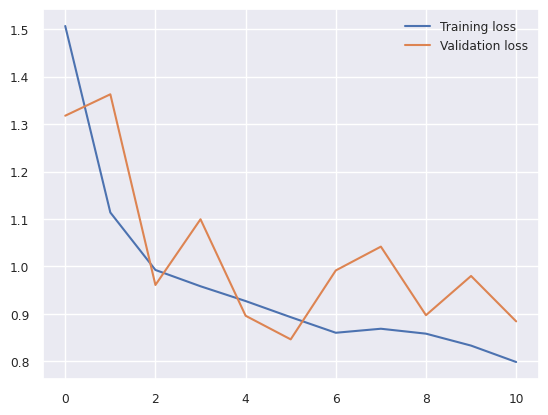

In [30]:
step = 0

#Training loop
train_losses = []
val_losses = []
patience = 5
best_loss = float('inf')
patience_counter = 0
best_val_loss = float('inf')
best_model_wts = None

for epoch in range(train_config['epochs']):
    try:
        # Model Training
        model.train()
        step += 1

        pbar = tqdm(train_dl)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = PixelwiseMetrics(data_config['n_classes'])

        for idx, (img, y) in enumerate(pbar):
            img, y = img.to(device), y.to(device)
            # load target
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # backward step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get prediction
            _, pred = torch.max(y_hat, dim=1)

            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)

            pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        train_losses.append(mean_loss)
        train_stats = {
                "train_loss": mean_loss.item(),
                "train_average_accuracy": metrics.get_average_accuracy(),
                "train_mIoU": metrics.get_mIoU(),
                **{
                    "train_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
                **{
                    "train_IoU_" + k: v
                    for k, v in metrics.get_IoU().items()
                },
            }
        print(train_stats)

        # Model Validation
        model.eval()
        pbar = tqdm(val_dl)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = PixelwiseMetrics(data_config['n_classes'])

        with torch.no_grad():
            for idx, (img, y) in enumerate(pbar):
                img, y = img.to(device), y.to(device)
                y = y.to(device)
                # model output
                y_hat = model(img)

                # loss computation
                loss = criterion(y_hat, y)

                # get prediction
                _, pred = torch.max(y_hat, dim=1)

                epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
                metrics.add_batch(y, pred)


                pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

            mean_loss = epoch_losses.mean()
            val_losses.append(mean_loss)
            val_stats = {
                "validation_loss": mean_loss.item(),
                "validation_average_accuracy": metrics.get_average_accuracy(),
                "validation_mIoU": metrics.get_mIoU(),
                **{
                    "validation_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
                **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
            }

            print(f"Epoch:{epoch}", val_stats)

            # Save model checkpoint every 2 epochs
            if epoch % 2 == 0:
                if epoch == 0:
                    continue

                save_weights_path = (
                    "../../drive/MyDrive/MVA/cp4_Unet_segmentation_epoch" + str(epoch) + ".pth"
                )
                save_opt_path = (
                    "../../drive/MyDrive/MVA/cp4_Unet_optimizer_epoch" + str(epoch) + ".pth"
                )
                torch.save(model.state_dict(), save_weights_path)
                torch.save(optimizer.state_dict(), save_opt_path)
            val_loss = val_stats["validation_loss"]
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                best_model = model.state_dict()
                best_epoch = epoch
                print("For now best val loss at epoch: ", epoch)
                # Enregistrez les meilleurs poids ici si désiré
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    torch.save(model.state_dict(), '../../drive/MyDrive/MVA/UNet_earlyStopped4_'+str(epoch)+'.pth')
                    break
    except Exception as e:
        print(f"An error occurred: {e}")

torch.save(best_model, "../../drive/MyDrive/MVA/UNet_4_"+str(best_epoch)+".pth")
print(f"Best model from validation saved to ../../drive/MyDrive/MVA/UNet_4")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
torch.save(model.state_dict(), train_config['model_path'])

## Test

In [12]:
def test(model, test_ld):
    model.eval()
    pbar = tqdm(test_ld)

    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['n_classes'])
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            img = img.to(device)
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)
            all_gts.append(y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        test_stats = {
            "test_loss": mean_loss.item(),
            "test_average_accuracy": metrics.get_average_accuracy(),
            "test_mIoU": metrics.get_mIoU(),
            **{
                "test_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
        print("Test stats:")

        # Loss
        print(f"  Loss: {test_stats['test_loss']:.4f}")

        # Average accuracy and mIoU
        print(f"  Average Accuracy: {test_stats['test_average_accuracy']:.4f}")
        print(f"  Mean IoU: {test_stats['test_mIoU']:.4f}")

        # Accuracy per class
        print("  Accuracy by Class:")
        for i in range(data_config['n_classes']):
            print(f"    Class {i}: {test_stats[f'test_accuracy_pixelclass_{i}']:.4f}")

        # IoU per class
        print("  IoU by Class:")
        for i in range(data_config['n_classes']):
            print(f"    Class {i}: {test_stats[f'train_IoU_class_{i}']:.4f}")
        all_preds = np.concatenate(all_preds)
        all_gts = np.concatenate(all_gts)

        # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(all_gts.flatten(), all_preds.flatten(), labels=np.arange(data_config['n_classes']))
        # Normalisation par lignes
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.set(font_scale=0.8)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_classes_13.values()), yticklabels=list(dict_classes_13.values()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #sns.set(font_scale=1.2)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    return

Validation Loss:0.8423: 100%|██████████| 17/17 [01:01<00:00,  3.59s/it]


Test stats:
  Loss: 0.8423
  Average Accuracy: 0.5306
  Mean IoU: 0.4175
  Accuracy by Class:
    Class 0: 0.8187
    Class 1: 0.4277
    Class 2: 0.4693
    Class 3: 0.2178
    Class 4: 0.9542
    Class 5: 0.6012
    Class 6: 0.8689
    Class 7: 0.3425
    Class 8: 0.9159
    Class 9: 0.6106
    Class 10: 0.6391
    Class 11: 0.0323
    Class 12: 0.0000
  IoU by Class:
    Class 0: 0.6372
    Class 1: 0.2094
    Class 2: 0.4567
    Class 3: 0.2101
    Class 4: 0.7954
    Class 5: 0.4703
    Class 6: 0.7259
    Class 7: 0.2745
    Class 8: 0.8371
    Class 9: 0.4428
    Class 10: 0.3352
    Class 11: 0.0322
    Class 12: 0.0000


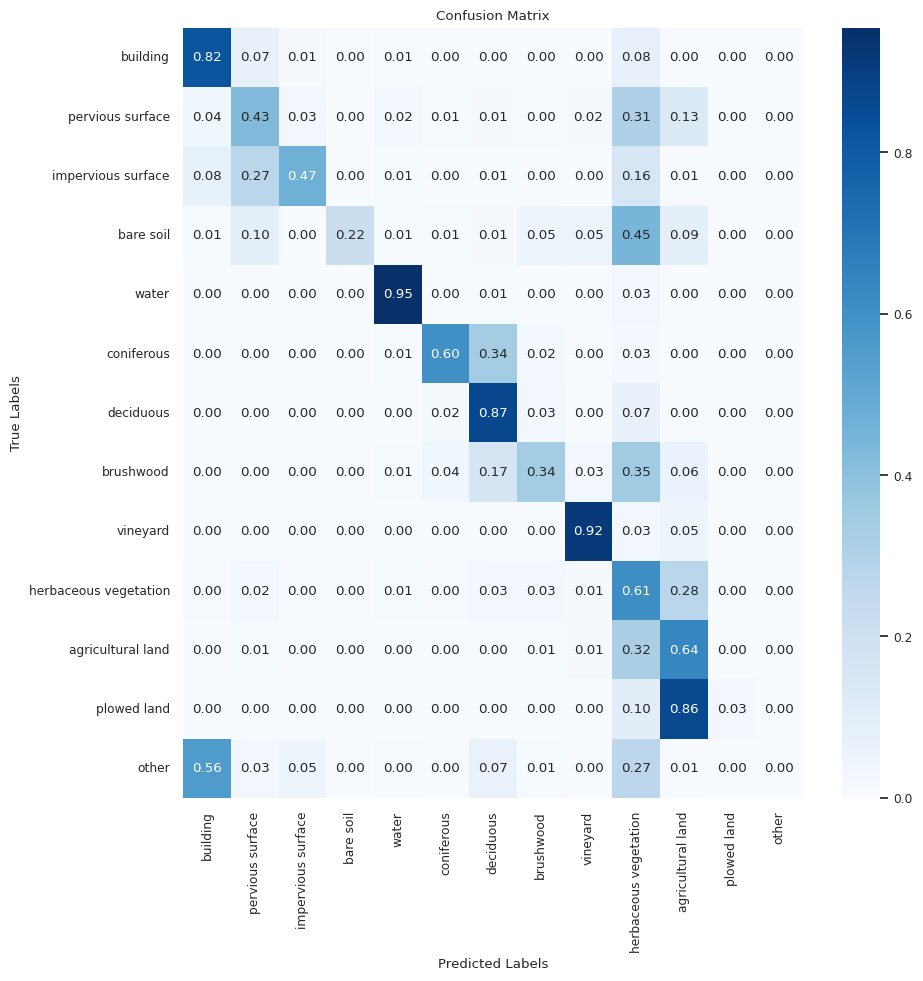

In [15]:
# create a new model's instance
model = UNet(n_classes=data_config['n_classes'], n_channels=data_config['n_inputs'])
model = model.to(device)

# load checkpoints weights
#model.load_state_dict(torch.load(train_config['model_path']))
model.load_state_dict(torch.load('../../drive/MyDrive/MVA/UNet_4_5.pth'))

test(model, test_dl)

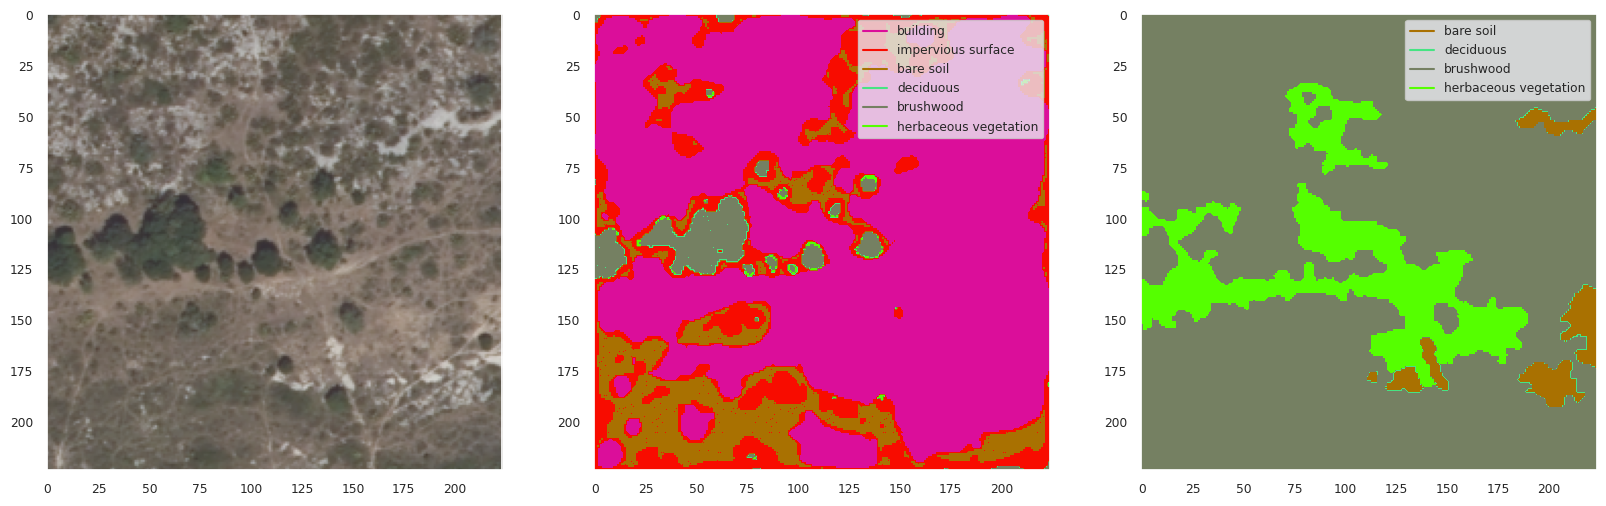

In [ ]:
img, target = next(iter(val_dl))
pred = model(img.cuda()).cpu().detach()
plot_pred(img[0], pred[0], target[0], dict_classes_13, colors_13)